<a href="https://colab.research.google.com/github/ethan-yoo/2022_aiffel_exp/blob/main/E09_Sentimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun  7 01:53:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

# **E09: 네이버 영화리뷰 감성분석하기**

> **데이터 출처: https://github.com/e9t/nsmc**

## **00. INDEX**

>01. 데이터 불러오기
>
>02. 데이터로더 구성
>> 인코딩/디코딩 함수 생성
>03. 모델 구성을 위한 데이터 분석 & 가공
>> 데이터셋 문장 길이 확인
>>
>> 최대 문장 길이 지정
>>
>> 패딩 처리
>04. 모델 구성 및 validation set 구성
>> RNN
>>
>> CNN
>>
>> Global Max Pooling
>>
>> validation set split
>05. 모델 훈련
>06. 훈련 결과 시각화
>07. 학습된 Embedding 레이어 분석
>> RNN
>>
>> CNN
>>
>> GMP
>08. 한국어 word2vec 임베딩 활용 성능 개선
>> 성능 개선 확인
>>
>> model rebuild
>>
>> model retrain
>09. 모델 개선
>> batch size 조절
>>
>> 성능 비교 시각화
>>
> 10. 회고

---

## **01. 데이터 불러오기**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 라이브러리 버전 확인
import pandas as pd
import numpy as np
import tensorflow as tf
import konlpy
from konlpy.tag import Mecab
import gensim
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


In [ ]:
# 파일 read

train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/E09/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/E09/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


---

## **02. 데이터로더 구성**

In [ ]:
# Mecab 오류 해결
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe am

In [ ]:
# Mecab으로 토큰화하기
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words):

    # 중복 지우기
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화 & 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
# 데이터 변환
num_words = 10000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words)

print('Done!')

Done!


### **인코딩/디코딩 함수 생성**

In [ ]:
# idx2wrd
index_to_word = {index:word for word, index in word_to_index.items()}

# 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개 문장 리스트 + 딕셔너리 = 인덱스로 변환
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 워드벡터 디코딩
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개 문장 디코딩
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print('Done!')

Done!


## **03.모델 구성을 위한 데이터 분석 및 가공**

### **데이터셋 문장 길이 확인**

In [ ]:
total_text_len = list(X_train) + list(X_test)

# 텍스트데이터 문장 길이 리스트 생성
num_tokens = [len(tokens) for tokens in total_text_len]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차 계산
print('평균: ', np.mean(num_tokens))
print('최대값: ', np.max(num_tokens))
print('표준편차: ', np.std(num_tokens))

평균:  15.969376315021577
최대값:  116
표준편차:  12.843535456326455


### **최대 문장 길이 지정**

In [ ]:
# 최대 길이 = 평균 + 표준편차*2
maxlen = int(np.mean(num_tokens) + np.std(num_tokens)*2)

print('malen: ', maxlen)
print('전체 문장의 {}%가 포함됨'.format(round(np.sum(num_tokens < maxlen)/len(num_tokens)*100, 3)))

malen:  41
전체 문장의 93.065%가 포함됨


### **패딩 처리**

In [ ]:
# RNN 모델에 맞게 pre 옵션으로 패딩
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                      value=word_to_index['<PAD>'],
                                                      padding='pre',
                                                      maxlen=maxlen)

print('Done!')

Done!


## **04. 모델 구성 및 validation set 구성**

### **RNN**

In [ ]:
# 단어사전
vocab_size = 10000

# 워드임베딩 벡터
word_vec_dim = 16

# relu, sigmoid RNN
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_19 (LSTM)              (None, 8)                 800       
                                                                 
 dense_54 (Dense)            (None, 8)                 72        
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### **CNN**

In [ ]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d_8 (Conv1D)           (None, None, 16)          1808      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_8 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_56 (Dense)            (None, 8)               

### **Global Max Pooling**

In [ ]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gmp.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_9 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_58 (Dense)            (None, 8)                 136       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### **validation set split**

In [ ]:
partial_x, x_val, partial_y, y_val = tts(X_train, y_train, test_size=0.2, random_state=17)

print('Done!')

Done!


## **05. 모델 훈련**

> 모델 훈련 & 시각화 함수는 홍성현님 [깃허브](https://github.com/seonghyun97/Aiffel_Exploration/blob/master/%5BE-09%5DMovieReview.ipynb)를 참고하였음

In [ ]:
# visualization Loss & Accuracy by epochs
def visualization(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # Loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.clf()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# model을 훈련시키고 평가해보는 함수
def fitting_machine(model,epoch):
    # model compile
    model = model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # model training and recording history
    history = model.fit(partial_x,
                        partial_y,
                        epochs=epoch,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    # print result
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'\nThis is {model.name}\nLoss: {results[0]}\nAccurancy: {results[1]}\n')
    
    return history

print('Done!')

Done!


In [ ]:
# rnn
rnn_history = fitting_machine(model_rnn, 7)

Epoch 1/7
229/229 [==============================] - 4s 9ms/step - loss: 0.4954 - accuracy: 0.7867 - val_loss: 0.3695 - val_accuracy: 0.8410
Epoch 2/7
229/229 [==============================] - 2s 7ms/step - loss: 0.3372 - accuracy: 0.8577 - val_loss: 0.3559 - val_accuracy: 0.8448
Epoch 3/7
229/229 [==============================] - 2s 7ms/step - loss: 0.3148 - accuracy: 0.8680 - val_loss: 0.3573 - val_accuracy: 0.8429
Epoch 4/7
229/229 [==============================] - 2s 7ms/step - loss: 0.3027 - accuracy: 0.8743 - val_loss: 0.3570 - val_accuracy: 0.8436
Epoch 5/7
229/229 [==============================] - 2s 7ms/step - loss: 0.2934 - accuracy: 0.8781 - val_loss: 0.3590 - val_accuracy: 0.8461
Epoch 6/7
229/229 [==============================] - 2s 7ms/step - loss: 0.2853 - accuracy: 0.8823 - val_loss: 0.3618 - val_accuracy: 0.8443
Epoch 7/7
229/229 [==============================] - 2s 7ms/step - loss: 0.2767 - accuracy: 0.8852 - val_loss: 0.3644 - val_accuracy: 0.8441
1537/1537 - 4

In [ ]:
# cnn
cnn_history = fitting_machine(model_cnn, 7)

Epoch 1/7
229/229 [==============================] - 2s 6ms/step - loss: 0.5044 - accuracy: 0.7431 - val_loss: 0.3689 - val_accuracy: 0.8383
Epoch 2/7
229/229 [==============================] - 1s 5ms/step - loss: 0.3288 - accuracy: 0.8600 - val_loss: 0.3578 - val_accuracy: 0.8448
Epoch 3/7
229/229 [==============================] - 1s 5ms/step - loss: 0.2938 - accuracy: 0.8785 - val_loss: 0.3493 - val_accuracy: 0.8491
Epoch 4/7
229/229 [==============================] - 1s 5ms/step - loss: 0.2646 - accuracy: 0.8926 - val_loss: 0.3555 - val_accuracy: 0.8487
Epoch 5/7
229/229 [==============================] - 1s 5ms/step - loss: 0.2346 - accuracy: 0.9084 - val_loss: 0.3716 - val_accuracy: 0.8479
Epoch 6/7
229/229 [==============================] - 1s 5ms/step - loss: 0.2015 - accuracy: 0.9243 - val_loss: 0.3958 - val_accuracy: 0.8438
Epoch 7/7
229/229 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9392 - val_loss: 0.4407 - val_accuracy: 0.8376
1537/1537 - 3

In [ ]:
# gmp
gmp_history = fitting_machine(model_gmp, 7)

Epoch 1/7
229/229 [==============================] - 2s 7ms/step - loss: 0.5925 - accuracy: 0.7524 - val_loss: 0.4471 - val_accuracy: 0.8160
Epoch 2/7
229/229 [==============================] - 2s 7ms/step - loss: 0.3810 - accuracy: 0.8392 - val_loss: 0.3723 - val_accuracy: 0.8349
Epoch 3/7
229/229 [==============================] - 1s 5ms/step - loss: 0.3273 - accuracy: 0.8616 - val_loss: 0.3605 - val_accuracy: 0.8419
Epoch 4/7
229/229 [==============================] - 1s 4ms/step - loss: 0.2991 - accuracy: 0.8752 - val_loss: 0.3591 - val_accuracy: 0.8437
Epoch 5/7
229/229 [==============================] - 1s 4ms/step - loss: 0.2785 - accuracy: 0.8855 - val_loss: 0.3628 - val_accuracy: 0.8438
Epoch 6/7
229/229 [==============================] - 1s 4ms/step - loss: 0.2614 - accuracy: 0.8934 - val_loss: 0.3695 - val_accuracy: 0.8419
Epoch 7/7
229/229 [==============================] - 1s 4ms/step - loss: 0.2468 - accuracy: 0.9006 - val_loss: 0.3775 - val_accuracy: 0.8404
1537/1537 - 2

## **06. 훈련 결과 시각화**

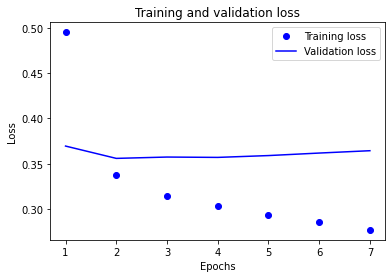

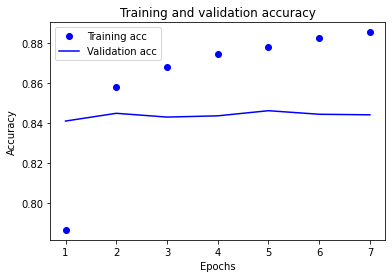

In [ ]:
# rnn
visualization(rnn_history)

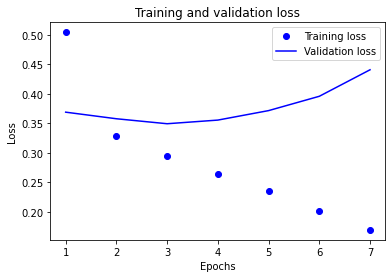

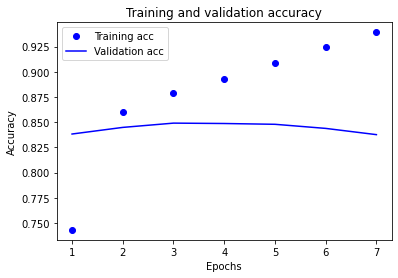

In [ ]:
# cnn
visualization(cnn_history)

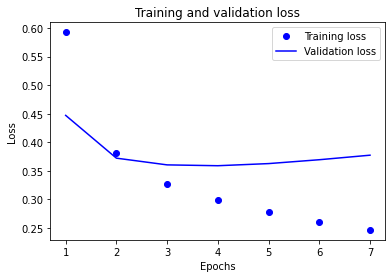

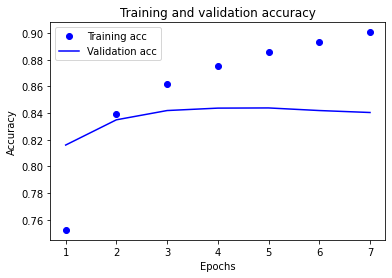

In [ ]:
# gmp
visualization(gmp_history)

## **07. 학습된 Embedding 레이어 분석**

### **RNN**

In [ ]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/AIFFEL/E09/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.04925205,  0.03105517,  0.04113806,  0.03907989,  0.02524313,
       -0.02584787,  0.00586793,  0.02041914,  0.02035635, -0.02582937,
       -0.00240666, -0.01327032, -0.04486413,  0.02928497, -0.01800389,
       -0.03624937], dtype=float32)

In [ ]:
word_vectors.similar_by_word('사랑')

[('세우', 0.9722590446472168),
 ('해석', 0.9712495803833008),
 ('대명사', 0.970474123954773),
 ('가벼움', 0.9663954973220825),
 ('해냈', 0.9643445014953613),
 ('구매', 0.9630481004714966),
 ('최민식', 0.9629431366920471),
 ('사실감', 0.9615585207939148),
 ('표한다', 0.9611522555351257),
 ('릿', 0.9610471129417419)]

▲ 연관이 높아 보이는 단어도 있고, 그렇지 않은 단어도 보입니다.

In [ ]:
word_vectors.similar_by_word('최고')

[('최고봉', 0.9795593023300171),
 ('시린', 0.9777662754058838),
 ('일품', 0.9770609140396118),
 ('시원시원', 0.9765172004699707),
 ('ㅠㅠㅠㅠ', 0.9760062098503113),
 ('그리움', 0.975368320941925),
 ('먹먹', 0.9750996232032776),
 ('슬퍼요', 0.9741134643554688),
 ('아름다워요', 0.9725567698478699),
 ('good', 0.9719381928443909)]

In [ ]:
word_vectors.similar_by_word('실망')

[('혐오', 0.988378643989563),
 ('졸작', 0.9859365224838257),
 ('광주', 0.9843347072601318),
 ('저질', 0.9835510849952698),
 ('발연기', 0.9835274815559387),
 ('올리버', 0.9809094667434692),
 ('당황', 0.9807533025741577),
 ('.,,', 0.9801250696182251),
 ('별루', 0.9798504114151001),
 ('아오', 0.9794697165489197)]

▲ 부정적인 단어는 비교적 잘 잡는 것 같습니다.

In [ ]:
word_vectors.similar_by_word('감동')

[('좋', 0.9513593316078186),
 ('듭니다', 0.9479687809944153),
 ('갑', 0.9197641611099243),
 ('짱', 0.9164116382598877),
 ('걸작', 0.9160469174385071),
 ('멋진', 0.9140505194664001),
 ('명화', 0.9068397879600525),
 ('줄리엣', 0.906275749206543),
 ('이뻐요', 0.9021357297897339),
 ('맘', 0.902101457118988)]

▲ 줄리엣, 명화, 걸작 정도까지는 어느 정도 이해가 되네요.

좋(아마 '좋다, 좋은, 좋-'이겠죠) 처럼 잘려나오는 단어들도 보입니다.

### **CNN**

In [ ]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/AIFFEL/E09/data/word2vec.txt'
f2 = open(word2vec_file_path, 'w')
f2.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f2.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f2.close()

word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector2 = word_vectors2['컴퓨터']
vector2

array([ 0.06486587, -0.10900137, -0.03470463, -0.05267156,  0.03083559,
       -0.00535413, -0.16405332, -0.02929867, -0.03303585,  0.15115935,
        0.08604542, -0.02110196, -0.11203799,  0.01062421,  0.00051838,
       -0.0124598 ], dtype=float32)

In [ ]:
word_vectors2.similar_by_word('사랑')

[('손색없', 0.8764262199401855),
 ('연말', 0.8744235634803772),
 ('친근', 0.8731305599212646),
 ('감격', 0.872710108757019),
 ('단순히', 0.865827739238739),
 ('ㅑ', 0.8655436635017395),
 ('뺐', 0.8591469526290894),
 ('매트릭스', 0.85252845287323),
 ('자존심', 0.8523714542388916),
 ('아키라', 0.8522768020629883)]

In [ ]:
word_vectors2.similar_by_word('최고')

[('탁월', 0.9377676844596863),
 ('챔피언', 0.9361021518707275),
 ('처절', 0.9247820377349854),
 ('독도', 0.9221043586730957),
 ('컴백', 0.9168250560760498),
 ('감탄사', 0.9154782891273499),
 ('박신혜', 0.9134947657585144),
 ('안다', 0.9124402403831482),
 ('오래도록', 0.9079256653785706),
 ('쫄깃', 0.9053670167922974)]

In [ ]:
word_vectors2.similar_by_word('실망')

[('역겨워', 0.9589092135429382),
 ('맛없', 0.9570329785346985),
 ('낚시', 0.9565696120262146),
 ('실패작', 0.9542481303215027),
 ('.-', 0.9474246501922607),
 ('그만두', 0.9443625211715698),
 ('디질', 0.9436076283454895),
 ('더러워지', 0.9368395805358887),
 ('심한', 0.9323322772979736),
 ('팝콘', 0.9317879676818848)]

In [ ]:
word_vectors2.similar_by_word('감동')

[('최신', 0.8860321044921875),
 ('친근', 0.8769975900650024),
 ('명불허전', 0.8466136455535889),
 ('쏘우', 0.8413317799568176),
 ('단연', 0.83614581823349),
 ('죽여야', 0.827816367149353),
 ('매염방', 0.826114296913147),
 ('권력', 0.8247969150543213),
 ('뿌듯', 0.8243390917778015),
 ('on', 0.8223711252212524)]

▲ 전반적으로 RNN 모델에 비해 조금 단조롭거나 뚝뚝 끊기는 느낌의 단어가 많네요.

.- 처럼 쓸데없는 문자가 잡히기도 합니다.

### **GMP**

In [ ]:
embedding_layer = model_gmp.layers[0]
weights = embedding_layer.get_weights()[0]
vocab_size, word_vector_dim = weights.shape[0], weights.shape[1]

word2vec_file_path = '/content/drive/MyDrive/AIFFEL/E09/data/word2vec.txt'
f3 = open(word2vec_file_path, 'w')
f3.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_gmp.get_weights()[0]
for i in range(4,vocab_size):
    f3.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f3.close()

word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector3 = word_vectors3['컴퓨터']
vector3

array([ 0.04051085, -0.10213774,  0.05686174, -0.06496321, -0.06799877,
       -0.04035151, -0.02655781,  0.02340064, -0.05558763, -0.08202055,
        0.06677703, -0.04659525,  0.01858167, -0.04926745, -0.09415722,
       -0.07917783], dtype=float32)

In [ ]:
word_vectors3.similar_by_word('사랑')

[('쿵푸', 0.9115050435066223),
 ('넘사벽', 0.9043145775794983),
 ('준', 0.8952242136001587),
 ('춤추', 0.8929998278617859),
 ('테이크', 0.881513237953186),
 ('소통', 0.8745929598808289),
 ('너머', 0.8742336630821228),
 ('5', 0.8717709183692932),
 ('이렇', 0.8684521913528442),
 ('웃', 0.8672879934310913)]

In [ ]:
word_vectors3.similar_by_word('최고')

[('슬퍼요', 0.7560446262359619),
 ('지나갈', 0.7445442080497742),
 ('평등', 0.7253490090370178),
 ('장학우', 0.7052932977676392),
 ('편한', 0.6974267959594727),
 ('계획', 0.695301353931427),
 ('친근', 0.6932628750801086),
 ('에이리언', 0.6902977824211121),
 ('성기', 0.6901509165763855),
 ('태양', 0.6829642057418823)]

In [ ]:
word_vectors3.similar_by_word('실망')

[('재앙', 0.941999614238739),
 ('연속극', 0.9182400703430176),
 ('설정', 0.9101114273071289),
 ('sm', 0.9051221013069153),
 ('사라졌', 0.9047355651855469),
 ('가위', 0.9009018540382385),
 ('불우', 0.8986130356788635),
 ('재탕', 0.8891335725784302),
 ('제정신', 0.8878833055496216),
 ('애쓴', 0.8875678777694702)]

In [ ]:
word_vectors3.similar_by_word('감동')

[('시절', 0.9348336458206177),
 ('으면서', 0.9020490646362305),
 ('악역', 0.8981361389160156),
 ('어떨까', 0.8979471921920776),
 ('무시무시', 0.8854531645774841),
 ('해피', 0.8838043212890625),
 ('목사', 0.8804962635040283),
 ('사람', 0.8745806217193604),
 ('겁내', 0.8664819002151489),
 ('강하', 0.8628451824188232)]

▲ 전반적으로 gmp는 모 아니면 도의 특성을 보입니다.

accuracy 수치만 보면 괜찮은 성능처럼 보이지만 실제로는 성능이 생각보다 좋지 않습니다.

## **08. 한국어 Word2Vec 임베딩 활용하여 성능 개선**

In [ ]:
# gensim 버전 확인
print(gensim.__version__)

3.6.0


### **성능 개선 확인**

In [ ]:
word2vec_path = '/content/drive/MyDrive/AIFFEL/E09/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [ ]:
word2vec.similar_by_word('감동')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [ ]:
word2vec.similar_by_word('최고')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('최대', 0.5721614360809326),
 ('최강', 0.5064552426338196),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037323236465454),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.44647401571273804),
 ('최초', 0.44505739212036133),
 ('최상', 0.4345606565475464)]

▲ 오... 성능이 확 올라간 걸 볼 수 있습니다.

### **model rebuild**

In [ ]:
vector.shape

(200,)

In [ ]:
# 단어사전
vocab_size = 10000

# 워드임베딩 벡터
word_vec_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vec_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

print('Done!')

Done!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [ ]:
embedding_matrix.shape

(10000, 200)

In [ ]:
# RNN_new
new_rnn = tf.keras.Sequential()
new_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_rnn.add(tf.keras.layers.LSTM(8))
new_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
new_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_rnn.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 lstm_13 (LSTM)              (None, 8)                 6688      
                                                                 
 dense_42 (Dense)            (None, 8)                 72        
                                                                 
 dense_43 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# CNN_new
new_cnn = tf.keras.Sequential()
new_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_cnn.add(tf.keras.layers.LSTM(8))
new_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
new_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_cnn.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 lstm_14 (LSTM)              (None, 8)                 6688      
                                                                 
 dense_44 (Dense)            (None, 8)                 72        
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GMP_new
new_gmp = tf.keras.Sequential()
new_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_gmp.add(tf.keras.layers.LSTM(8))
new_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
new_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_gmp.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 lstm_15 (LSTM)              (None, 8)                 6688      
                                                                 
 dense_46 (Dense)            (None, 8)                 72        
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


### **model retrain**

In [ ]:
# rnn
new_rnn_hist = fitting_machine(new_rnn, 7)

Epoch 1/7
229/229 [==============================] - 4s 11ms/step - loss: 0.5400 - accuracy: 0.7182 - val_loss: 0.4272 - val_accuracy: 0.8063
Epoch 2/7
229/229 [==============================] - 2s 9ms/step - loss: 0.3702 - accuracy: 0.8406 - val_loss: 0.3701 - val_accuracy: 0.8373
Epoch 3/7
229/229 [==============================] - 2s 9ms/step - loss: 0.3222 - accuracy: 0.8655 - val_loss: 0.3602 - val_accuracy: 0.8451
Epoch 4/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2981 - accuracy: 0.8777 - val_loss: 0.3600 - val_accuracy: 0.8470
Epoch 5/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2799 - accuracy: 0.8865 - val_loss: 0.3613 - val_accuracy: 0.8492
Epoch 6/7
229/229 [==============================] - 2s 9ms/step - loss: 0.2671 - accuracy: 0.8932 - val_loss: 0.3620 - val_accuracy: 0.8480
Epoch 7/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2528 - accuracy: 0.8996 - val_loss: 0.3737 - val_accuracy: 0.8472
1537/1537 - 

In [ ]:
# cnn
new_cnn_hist = fitting_machine(new_cnn, 7)

Epoch 1/7
229/229 [==============================] - 4s 11ms/step - loss: 0.5236 - accuracy: 0.7324 - val_loss: 0.4093 - val_accuracy: 0.8185
Epoch 2/7
229/229 [==============================] - 2s 8ms/step - loss: 0.3639 - accuracy: 0.8441 - val_loss: 0.3677 - val_accuracy: 0.8416
Epoch 3/7
229/229 [==============================] - 2s 8ms/step - loss: 0.3205 - accuracy: 0.8662 - val_loss: 0.3589 - val_accuracy: 0.8446
Epoch 4/7
229/229 [==============================] - 2s 9ms/step - loss: 0.2971 - accuracy: 0.8764 - val_loss: 0.3545 - val_accuracy: 0.8487
Epoch 5/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2770 - accuracy: 0.8867 - val_loss: 0.3597 - val_accuracy: 0.8490
Epoch 6/7
229/229 [==============================] - 2s 9ms/step - loss: 0.2622 - accuracy: 0.8931 - val_loss: 0.3613 - val_accuracy: 0.8482
Epoch 7/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2511 - accuracy: 0.8991 - val_loss: 0.3698 - val_accuracy: 0.8480
1537/1537 - 

In [ ]:
# gmp
new_gmp_hist = fitting_machine(new_gmp, 7)

Epoch 1/7
229/229 [==============================] - 4s 11ms/step - loss: 0.5163 - accuracy: 0.7376 - val_loss: 0.4038 - val_accuracy: 0.8197
Epoch 2/7
229/229 [==============================] - 2s 8ms/step - loss: 0.3606 - accuracy: 0.8451 - val_loss: 0.3677 - val_accuracy: 0.8371
Epoch 3/7
229/229 [==============================] - 2s 9ms/step - loss: 0.3210 - accuracy: 0.8650 - val_loss: 0.3588 - val_accuracy: 0.8437
Epoch 4/7
229/229 [==============================] - 2s 11ms/step - loss: 0.2996 - accuracy: 0.8749 - val_loss: 0.3611 - val_accuracy: 0.8454
Epoch 5/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2826 - accuracy: 0.8842 - val_loss: 0.3625 - val_accuracy: 0.8457
Epoch 6/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2687 - accuracy: 0.8907 - val_loss: 0.3631 - val_accuracy: 0.8451
Epoch 7/7
229/229 [==============================] - 2s 8ms/step - loss: 0.2568 - accuracy: 0.8969 - val_loss: 0.3679 - val_accuracy: 0.8460
1537/1537 -

▲ 목표 accuracy 0.85보다 조금 모자랍니다.

batch_size를 조절해서 목표를 달성해봅시다.

---

## **09. 모델 개선**


### **batch size 조절**

In [ ]:
def fitting_machine2(model,epoch):
    # model compile
    model = model
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # model training and recording history
    history = model.fit(partial_x,
                        partial_y,
                        epochs=epoch,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)
    # print result
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(f'\nThis is {model.name}\nLoss: {results[0]}\nAccurancy: {results[1]}\n')
    
    return history

print('Done!')

Done!


In [ ]:
# RNN_new2
new_rnn2 = tf.keras.Sequential()
new_rnn2.add(tf.keras.layers.Embedding(vocab_size, word_vec_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen,
                                      trainable=True))
new_rnn2.add(tf.keras.layers.LSTM(16))
new_rnn2.add(tf.keras.layers.Dense(8, activation='relu'))
new_rnn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

new_rnn2.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 lstm_18 (LSTM)              (None, 16)                13888     
                                                                 
 dense_52 (Dense)            (None, 8)                 136       
                                                                 
 dense_53 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


▲ 파라미터 수가 늘어났습니다. 당연히 성능도 올라가겠죠?

In [ ]:
# rnn2
new_rnn_hist2 = fitting_machine2(new_rnn2, 7)

Epoch 1/7
3655/3655 [==============================] - 24s 6ms/step - loss: 0.4004 - accuracy: 0.8184 - val_loss: 0.3537 - val_accuracy: 0.8445
Epoch 2/7
3655/3655 [==============================] - 22s 6ms/step - loss: 0.3100 - accuracy: 0.8695 - val_loss: 0.3381 - val_accuracy: 0.8544
Epoch 3/7
3655/3655 [==============================] - 22s 6ms/step - loss: 0.2738 - accuracy: 0.8870 - val_loss: 0.3413 - val_accuracy: 0.8540
Epoch 4/7
3655/3655 [==============================] - 22s 6ms/step - loss: 0.2443 - accuracy: 0.9003 - val_loss: 0.3492 - val_accuracy: 0.8548
Epoch 5/7
3655/3655 [==============================] - 22s 6ms/step - loss: 0.2171 - accuracy: 0.9131 - val_loss: 0.3705 - val_accuracy: 0.8485
Epoch 6/7
3655/3655 [==============================] - 23s 6ms/step - loss: 0.1933 - accuracy: 0.9238 - val_loss: 0.3845 - val_accuracy: 0.8520
Epoch 7/7
3655/3655 [==============================] - 22s 6ms/step - loss: 0.1710 - accuracy: 0.9349 - val_loss: 0.4036 - val_accuracy:

▲ 목표로 했던 accuracy 0.85를 달성했습니다.

### **성능 비교 시각화**

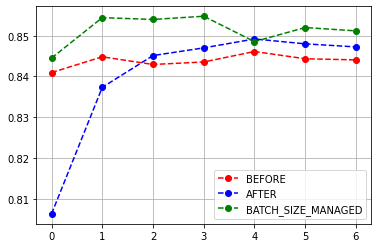

In [ ]:
plt.plot(rnn_history.history['val_accuracy'], '--o', color='red', label='BEFORE')
plt.plot(new_rnn_hist.history['val_accuracy'], '--o', color='blue', label='AFTER')
plt.plot(new_rnn_hist2.history['val_accuracy'], '--o', color='green', label='BATCH_SIZE_MANAGED')
plt.legend()
plt.grid()

▲ epoch=2부터 한국어 word2vec 모델이 힘을 발휘합니다.

또, 배치 사이즈를 줄여서 더 세밀하게 보도록 조정해주면 처음부터 다른 두 모델에 비해 훨씬 나은 성능을 보여주는 것을 알 수 있습니다.

---

## **10. 회고**

- 아직 Going Deeper 가기 전인데 슬슬 어려운 내용이 나오기 시작하는 것 같습니다.
- 밀린 펀더멘털 노드 중에 안 읽은 부분이 있어서 이번 익스를 하면서 같이 참고해서 진행했습니다.
- 최근 익스들을 하다보면 CS 능력의 부족함에 점점 더 압박감이 듭니다. 얼마 전에 백준을 시작했는데... 도움이 됐으면 좋겠네요.
- 임베딩 부분 이해가 아직 100% 완벽하지 않은 것 같습니다. 밑시딥 책 다시 뒤져보러 갑니다....😢

**끝!**